In [1]:
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the 3-D volume from the ADDITIONAL DATA SECTION of: https://www.ebi.ac.uk/emdb/EMD-15056

tomo_file = ''

with mrcfile.open(tomo_file) as mrc:
    tomo_full = mrc.data[:, ::-1, :]  # flip to match emdb
    tomo_voxel = mrc.voxel_size.x
    mrc.close()   

In [4]:
y_start = 25
y_stop = 525

x_start = 112
x_stop = 612

z_sub = 232
z_noise = 95
    
# Pick region of tomogram to denoise, denoise just this slice for simplicity
subtomo_slice = tomo_full[z_sub, y_start:y_stop, x_start:x_stop]

# Select a noise slice for whitening transform
noise_slice = tomo_full[z_noise, y_start:y_stop, x_start:x_stop]
# noise_slice = tomo_full[z_noise, 250:750, 250:750]

tomo_slice = tomo_full[z_sub]

print(tomo_full.shape, tomo_voxel)

(464, 928, 928) 14.08


In [5]:
# You will need the 3-D volume from: https://www.ebi.ac.uk/emdb/EMD-15056

tomo_file_denoised = ''

with mrcfile.open(tomo_file_denoised) as mrc:
    tomo_denoised = mrc.data[:, ::-1, :]  # flip to match emdb
    subtomo_denoised = tomo_denoised[z_sub, y_start:y_stop, x_start:x_stop]
    mrc.close()  

In [6]:
shape = subtomo_slice.shape

r = shape[0] // 2
r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in shape]))/2))

signal_slice_raps = fsc.compute_spherically_averaged_power_spectrum(subtomo_slice, r_corner) 
noise_slice_raps = fsc.compute_spherically_averaged_power_spectrum(noise_slice, r_corner)

freq = fsc.get_radial_spatial_frequencies(subtomo_slice, tomo_voxel)

In [7]:
# whiten the subtomogram
y_whitened = fsc.whitening_transform(subtomo_slice, noise_slice, r_corner)

# upsample
y_upsample = fsc.fourier_upsample(y_whitened, 2)

In [8]:
EPSILON = 1e-8

### compute the SFSC ###
sfsc_upsample = np.mean(fsc.single_image_frc(y_upsample, r, whiten_upsample=True), axis=0)
sfsc_upsample = np.where(sfsc_upsample > EPSILON, sfsc_upsample, EPSILON)

# # or the following approximately equal alternatives
# ssnr_estimate = (signal_slice_raps[:r] - noise_slice_raps[:r]) / noise_slice_raps[:r]
# fsc_from_ssnr = ssnr_estimate / (1 + ssnr_estimate)
# fsc_from_ssnr = np.where(fsc_from_ssnr > EPSILON, fsc_from_ssnr, EPSILON)

# ps_w = fsc.compute_spherically_averaged_power_spectrum(y_whitened, r)
# fsc_from_ps = (ps_w - 1) / ps_w
# fsc_from_ps = np.where(fsc_from_ps > EPSILON, fsc_from_ps, EPSILON)

In [9]:
### apply a Wiener filter based on the SFSC ###

Yw = fsc.ft2(y_whitened)
rdists = fsc.radial_distance_grid(Yw.shape)

for ri in range(r)[2:]:  # pick range of shells to filter
    mask = fsc.shell_mask(rdists, ri)
    Yw[mask] = sfsc_upsample[ri] * Yw[mask] * np.sqrt(noise_slice_raps[ri])

# # #optional step - additional low-pass filter based on e.g. 1/7 threshold
res = fsc.linear_interp_resolution(sfsc_upsample[2:], freq[2:], v=1/7)
m_idx = np.argmin(abs(freq - 1/res))
sphere_mask = fsc.sphere_mask(rdists, m_idx)
Yw = sphere_mask * Yw

y_filtered = fsc.ift2(Yw)

print(res)

72.61


In [10]:
# Low-pass filter for comparison to Wiener filter
### *** move this to after calculating the resolution
subtomo_lpf = fsc.low_pass_filter(subtomo_slice, tomo_voxel, res)

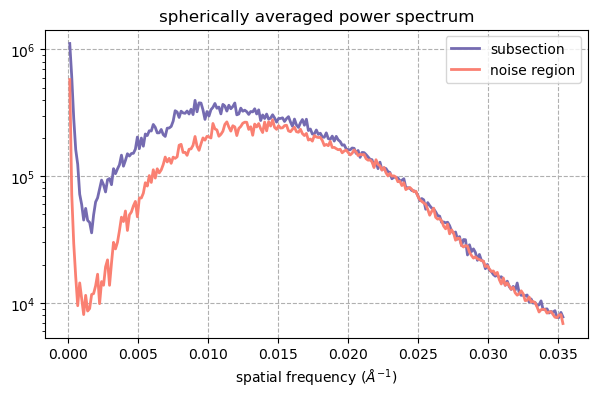

In [11]:
plt.figure(figsize=(7,4))

plt.semilogy(freq[1:], signal_slice_raps[1:r], color=cmap_a[3], linewidth=2, label='subsection')
plt.semilogy(freq[1:], noise_slice_raps[1:r], color='salmon', linewidth=2, label='noise region') 

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')

plt.legend()
# plt.savefig('')
plt.show()

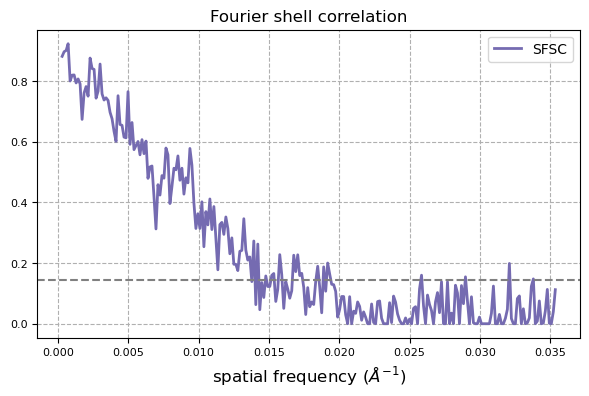

In [12]:
plt.figure(figsize=(7,4))

plt.plot(freq[2:], sfsc_upsample[2:], color=cmap_a[3], linewidth=2, label='SFSC')

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')

plt.legend()
plt.axhline(1/7, linestyle='--', color='grey')
# plt.savefig('')
plt.show()

In [13]:
u = np.mean(tomo_slice)
s = np.mean(tomo_slice)

u_s = np.mean(subtomo_slice)
s_s = np.std(subtomo_slice)

u_wf = np.mean(y_filtered)
s_wf = np.std(y_filtered)

u_lpf = np.mean(subtomo_lpf)
s_lpf = np.std(subtomo_lpf)

u_eps = np.mean(noise_slice)
s_eps = np.std(noise_slice)

u_cc = np.mean(subtomo_denoised)
s_cc = np.std(subtomo_denoised)

			full tomogram slice


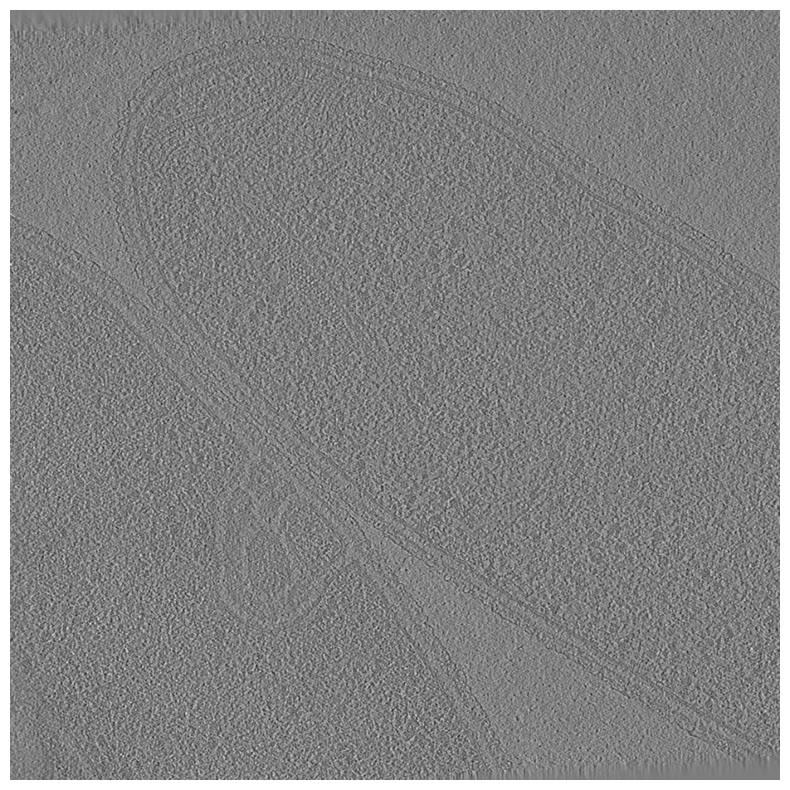

	sub tomogram slice


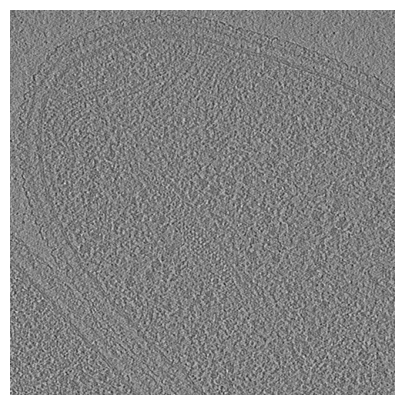

	sub tomogram slice lpf


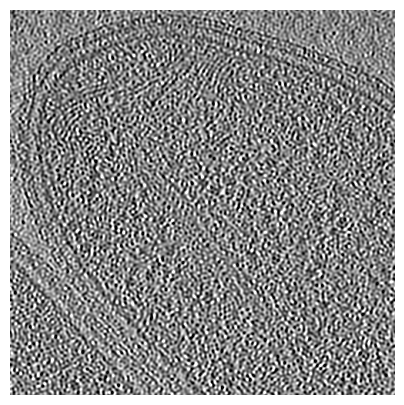

	sub tomogram slice cryo-CARE


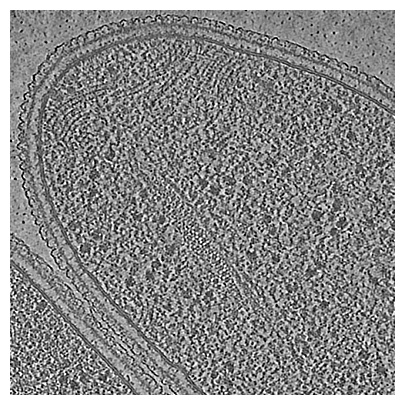

sub tomogram slice Wiener filter


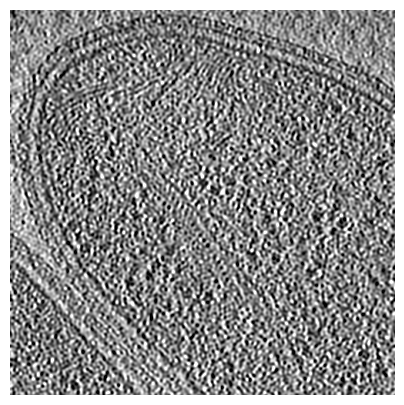

In [14]:
print("\t\t\tfull tomogram slice")
plt.figure(figsize=(10,10))
plt.imshow(tomo_full[z_sub, ...], cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

# print("\tsub tomogram noise slice")
# plt.figure(figsize=(5,5))
# plt.imshow(noise_slice, cmap='gray')
# plt.axis('off')
# # plt.savefig('')
# plt.show()

print("\tsub tomogram slice")
plt.figure(figsize=(5,5))
plt.imshow(subtomo_slice, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

print("\tsub tomogram slice lpf")
plt.figure(figsize=(5,5))
# plt.imshow(subtomo_lpf, cmap='gray')
plt.imshow(subtomo_lpf, cmap='gray', vmin=u_lpf-(2*s_lpf), vmax=u_lpf+(2*s_lpf))  # auto adjust contrast
plt.axis('off')
# plt.savefig('')
plt.show()

print("\tsub tomogram slice cryo-CARE")
plt.figure(figsize=(5,5))
# plt.imshow(subtomo_denoised, cmap='gray')
plt.imshow(subtomo_denoised, cmap='gray', vmin=u_cc-(2*s_cc), vmax=u_cc+(2*s_cc))  # auto adjust contrast
plt.axis('off')
# plt.savefig('')
plt.show()

print("sub tomogram slice Wiener filter")
plt.figure(figsize=(5,5))
# plt.imshow(y_filtered, cmap='gray')
plt.imshow(y_filtered, cmap='gray', vmin=u_wf-(2*s_wf), vmax=u_wf+(2*s_wf))  # auto adjust contrast
plt.axis('off')
# plt.savefig('')
plt.show()

In [18]:
#####


# this section is for the supplemental tomogram ctf figure


#####

In [30]:
### you will need the tilt series file tomo2_L1G1 in the 2020-10-22 folder from: https://www.ebi.ac.uk/empiar/EMPIAR-11058/

tilt_file = ''

with mrcfile.open(tilt_file, permissive=True) as mrc:
    stack = mrc.data
    tilt_voxel = mrc.voxel_size.x
    mrc.close()

zero_tilt_idx = stack.shape[0] // 2  # should be zero deg tilt
    
tilt = stack[zero_tilt_idx][:, ::-1]
tilt_ft = fsc.ft2(tilt)

ds_tilt = fsc.fourier_downsample(tilt, 4)  # match reconstruction size
ds_tilt_ft = fsc.ft2(ds_tilt)

tomo_slice_ft = fsc.ft2(tomo_slice)

tilt_freq = fsc.get_radial_spatial_frequencies(tilt, tilt_voxel)
ds_freq = fsc.get_radial_spatial_frequencies(ds_tilt, 4*tilt_voxel)
tomo_freq = fsc.get_radial_spatial_frequencies(tomo_slice, tomo_voxel)

In [31]:
N_tilt = tilt.shape[0]
r_tilt = N_tilt // 2

N_ds = ds_tilt.shape[0]
r_ds = N_ds // 2

N_tomo = tomo_slice.shape[0]
r_tomo = N_tomo // 2

tilt_psd = fsc.compute_spherically_averaged_power_spectrum(tilt, r_tilt)
ds_psd = fsc.compute_spherically_averaged_power_spectrum(ds_tilt, r_ds)
tomo_psd = fsc.compute_spherically_averaged_power_spectrum(tomo_slice, r_tomo)

In [32]:
u_tomo = np.mean(tomo_slice)
s_tomo = np.std(tomo_slice)
u_tomo_ft = np.mean(fsc.log_abs(tomo_slice_ft))
s_tomo_ft = np.std(fsc.log_abs(tomo_slice_ft))

u_tilt = np.mean(tilt)
s_tilt = np.std(tilt)
u_tilt_ft = np.mean(fsc.log_abs(tilt_ft))
s_tilt_ft = np.std(fsc.log_abs(tilt_ft))

u_ds_tilt = np.mean(ds_tilt)
s_ds_tilt = np.std(ds_tilt)
u_ds_tilt_ft = np.mean(fsc.log_abs(ds_tilt_ft))
s_ds_tilt_ft = np.std(fsc.log_abs(ds_tilt_ft))

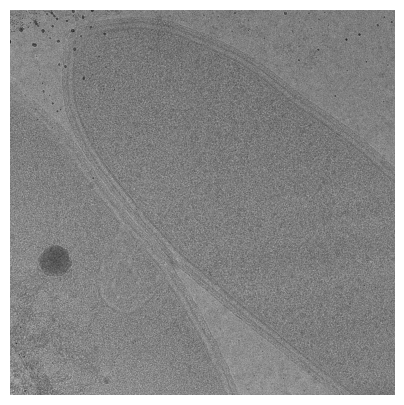

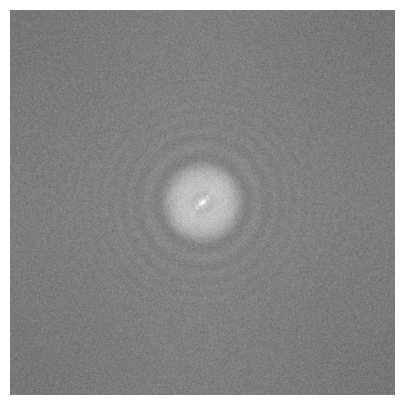

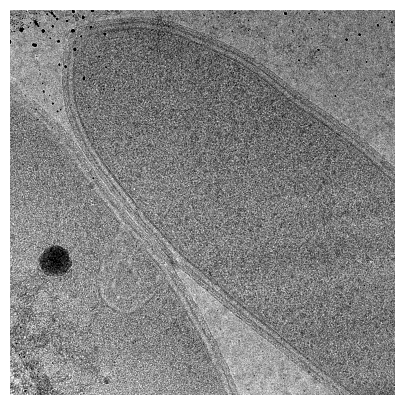

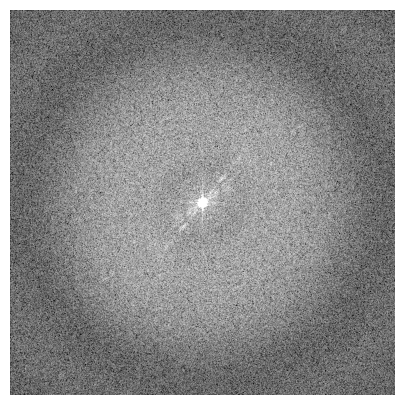

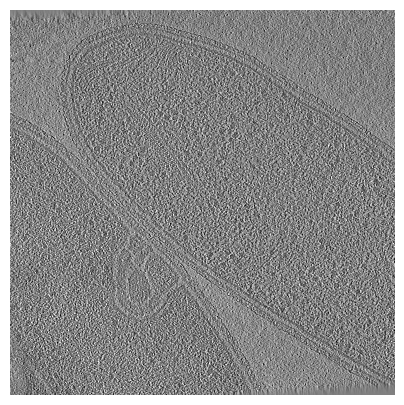

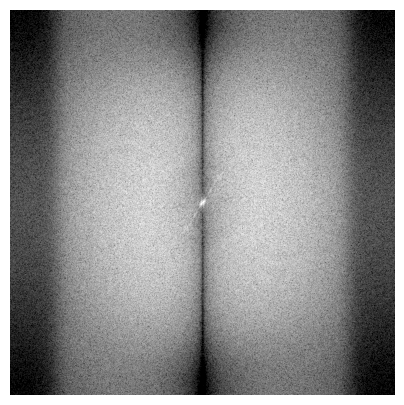

In [53]:
plt.figure(figsize=(5,5))
plt.imshow(tilt, cmap='gray', vmin=u_tilt - 2*s_tilt, vmax=u_tilt + 2*s_tilt)
# plt.imshow(tilt, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(fsc.log_abs(tilt_ft), cmap='gray', vmin=u_tilt_ft - 2*s_tilt_ft, vmax=u_tilt_ft + 2*s_tilt_ft)
# plt.imshow(fsc.log_abs(tilt_ft), cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(ds_tilt, cmap='gray', vmin=u_ds_tilt - 2*s_ds_tilt, vmax=u_ds_tilt + 2*s_ds_tilt)
# plt.imshow(ds_tilt, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(fsc.log_abs(ds_tilt_ft), cmap='gray', vmin=u_ds_tilt_ft - 2*s_ds_tilt_ft, vmax=u_ds_tilt_ft + 2*s_ds_tilt_ft)
# plt.imshow(fsc.log_abs(ds_tilt_ft), cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(tomo_slice, cmap='gray', vmin=u_tomo - 2*s_tomo, vmax=u_tomo + 2*s_tomo)
# plt.imshow(tomo_slice, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(fsc.log_abs(tomo_slice_ft), cmap='gray', vmin=u_tomo_ft - 2*s_tomo_ft, vmax=u_tomo_ft + 2*s_tomo_ft)
# plt.imshow(tilt, cmap='gray')
plt.axis('off')
# plt.savefig('')
plt.show()

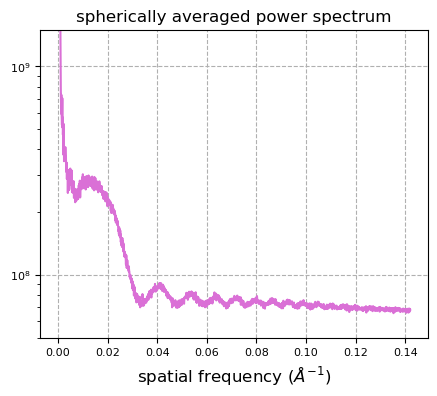

In [50]:
plt.figure(figsize=(5,4))
plt.semilogy(tilt_freq, tilt_psd, color='orchid')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')
plt.ylim(5e7, 1.5e9)
# plt.savefig('')
plt.show()

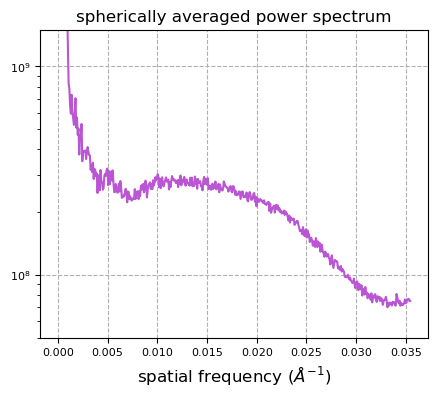

In [51]:
plt.figure(figsize=(5,4))
plt.semilogy(ds_freq, ds_psd, color='mediumorchid')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')
plt.ylim(5e7, 1.5e9)
# plt.savefig('')
plt.show()

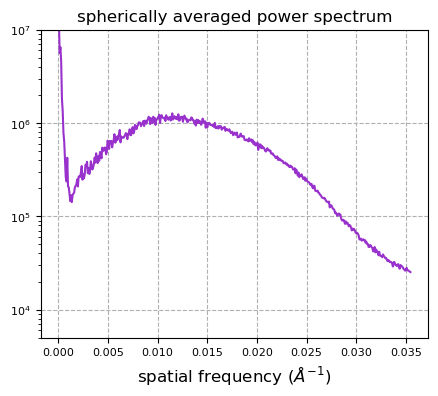

In [42]:
plt.figure(figsize=(5,4))
plt.semilogy(tomo_freq, tomo_psd, color='darkorchid')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')
plt.ylim(5e3, 1e7)
# plt.savefig('')
plt.show()